In [1]:
import numpy as np
import matplotlib.pyplot as plt


class My:
	def __init__(self, mu, cov, p, num_points):
		self.mu = mu
		self.cov = cov
		self.p = p  # 类别先验概率
		self.num_points = num_points
		self.random_points = np.random.multivariate_normal(mu, cov, num_points)

		# 计算常量项并存储
		n = len(mu)
		self.constant_term = -(n / 2) * np.log(2 * np.pi) - (1 / 2) * np.log(np.linalg.det(cov)) + np.log(p)
		self.inv_cov = np.linalg.inv(self.cov)

	def draw(self, plt, co):
		plt.scatter(self.random_points[:, 0], self.random_points[:, 1], color=co, s=3)
		# 生成网格点
		span = 2
		x_m = self.random_points[:, 0]
		y_m = self.random_points[:, 1]
		x = np.linspace(-span + min(x_m), span + max(x_m), 100)
		y = np.linspace(-span + min(y_m), span + max(y_m), 100)
		X, Y = np.meshgrid(x, y)
		
		# 计算每个点的概率密度
		pos = np.dstack((X, Y))

		# 计算概率密度函数
		Z = (1 / (2 * np.pi * np.sqrt(np.linalg.det(self.cov)))) * \
			np.exp(-0.5 * np.einsum('...i,ij,...j->...', pos - self.mu, np.linalg.inv(self.cov), pos - self.mu))

		# 绘制等高线图
		plt.contour(X, Y, Z, levels=3, colors=co)

	def bayesian_log_likelihood(self, x, y):
		# 计算协方差矩阵的逆
		# 计算 (x - mu)
		diff = np.array([x, y]) - self.mu
		# 计算对数判别函数值
		log_likelihood = self.constant_term - (1 / 2) * (diff.T @ self.inv_cov @ diff)
		
		return log_likelihood

In [2]:
def drawline(a1, a2, plt, x_range=(-5, 5), y_range=(-5, 5)):
	mean_sub = np.array(a1.mu) - np.array(a2.mu)
	mean_add = np.array(a1.mu) + np.array(a2.mu)
	con_inv = np.linalg.inv(a1.cov)

	# 计算 w 向量
	w = con_inv @ mean_sub

	# 计算 sij 项
	cacl_sij = np.log(a1.p/a2.p) / (mean_sub.T @ con_inv @ mean_sub)

	# 计算 x0
	x0 = (mean_add) / 2 - cacl_sij * mean_sub
	# 创建 x1 的取值范围
	x1 = np.linspace(x_range[0], x_range[1], 100)
	
	# 计算对应的 x2
	if w[1] != 0:
		x2 = -(w[0] / w[1]) * x1 + (w[0] * x0[0] + w[1] * x0[1]) / w[1]
	else:
		# 当 w[1] = 0 时，直线为垂直线，x1 固定
		x1 = np.array([x0[0], x0[0]])
		x2 = np.array([y_range[0], y_range[1]])
	
	# 绘制直线
	plt.plot(x1, x2, label=f"w^T(x - x0) = 0")
	
	# 标记 x0 点
	plt.scatter(x0[0], x0[1], color="green", label="x0")
	
	# 设置图像范围
	plt.set_xlim(x_range)
	plt.set_ylim(y_range)
	# 设置图像

def test1(a1, a2):

	# 创建一个 1x2 的子图
	fig, axs = plt.subplots(1, 2, figsize=(12, 6))

	# 第一个子图
	axs[0].set_title("Points from First Normal Distribution")
	a1.draw(axs[0], "blue")
	a2.draw(axs[0], "red")
	axs[0].set_xticks(np.arange(-10, 10, 0.5))  # 设置x轴刻度从-5到5，间隔为0.5
	axs[0].set_yticks(np.arange(-10, 10, 0.5))  # 设置x轴刻度从-5到5，间隔为0.5
	axs[0].grid(color='gray', linestyle='--', linewidth=0.5)  # 自定义网格参数
	axs[0].axis("equal")

	# 第二个子图
	axs[1].set_title("Points from Second Disguss Distribution")
	axs[1].set_xticks(np.arange(-10, 10, 0.5))  # 设置x轴刻度从-5到5，间隔为0.5
	axs[1].set_yticks(np.arange(-10, 10, 0.5))  # 设置x轴刻度从-5到5，间隔为0.5
	axs[1].grid(color='gray', linestyle='-', linewidth=0.5)  # 自定义网格参数
	axs[1].axis("equal")

	# 在两幅子图中标记点
	for point in a1.random_points:
		x, y = point
		if a1.bayesian_log_likelihood(x, y) > a2.bayesian_log_likelihood(x, y):
			co = "blue"
		else:
			co = "red"
		# 在第一个子图上标记
		axs[1].scatter(x, y, color=co, s=3)

	for point in a2.random_points:
		x, y = point
		if a2.bayesian_log_likelihood(x, y) > a1.bayesian_log_likelihood(x, y):
			co = "red"
		else:
			co = "blue"
		# 在第二个子图上标记
		axs[1].scatter(x, y, color=co, s=3)
	

	drawline(a1, a2, axs[1])
	drawline(a1, a2, axs[0])

	# 显示所有子图
	plt.tight_layout()
	plt.show()

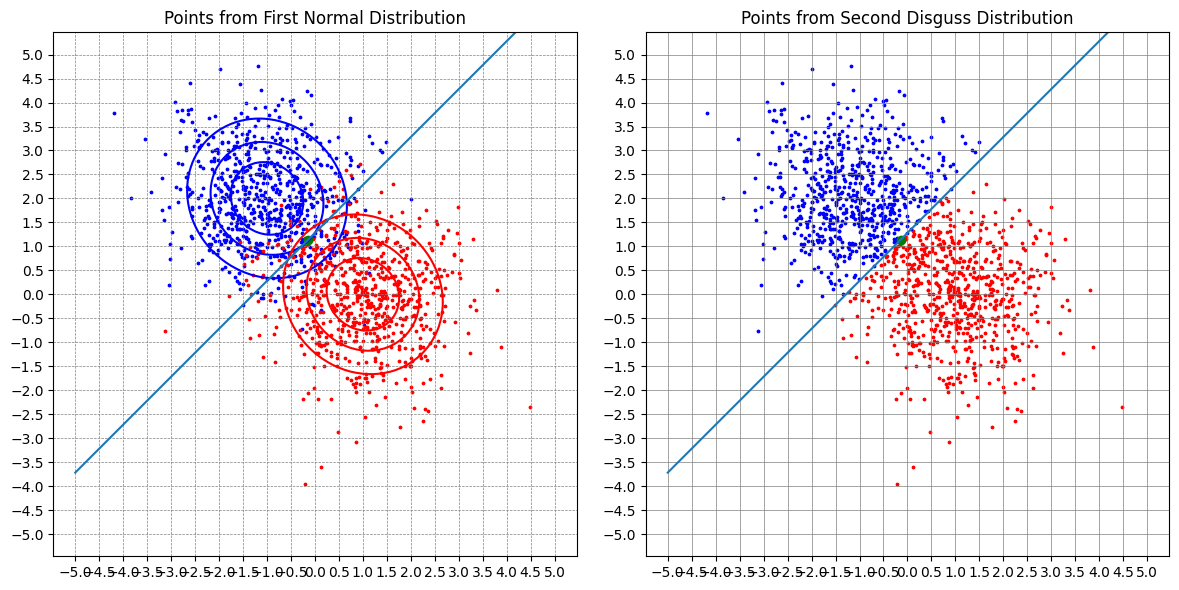

In [3]:
Cov = [[1, -0.1], [-0.1, 1]]
mu1, mu2 = [-1, 2], [1, 0]
num = 700
a1 = My(mu1, Cov, 0.3, num)
a2 = My(mu2, Cov, 0.5, num)
# 调用 test1 函数
test1(a1, a2)